# Курсовой проект

## Задание

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

##### Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Обзор данных

#### Описание датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита (сумма , которую предстоит еще выплатить)
* **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* **Monthly Debt** - ежемесячный долг (ежемесячная сумма к выплате)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Загрузка библиотек

In [666]:
import pandas as pd
import numpy as np
from pathlib import Path
import math
import random

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import random

import warnings
warnings.filterwarnings('ignore')

### Пути к директориям и файлам

In [667]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [668]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [669]:
df_train.shape

(7500, 17)

In [670]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [671]:
df_test.shape

(2500, 16)

In [672]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

### Оптимизация занимаемой памяти

In [673]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df


In [674]:
#df_train = optimizing_df(df_train)
#df_test = optimizing_df(df_test)

#Переносим в конец

### Типы данных

In [675]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

## Изучение признаков -  Feature Exploring  

#### Выделение признакового описания и целевой переменной

In [676]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Bankruptcies', 'Months since last delinquent',
                    'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Home Ownership', 'Years in current job', 
                    'Purpose', 'Term' ]

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Credit Score', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Debt', 'Bankruptcies']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

### Целевая переменная - Credit Default

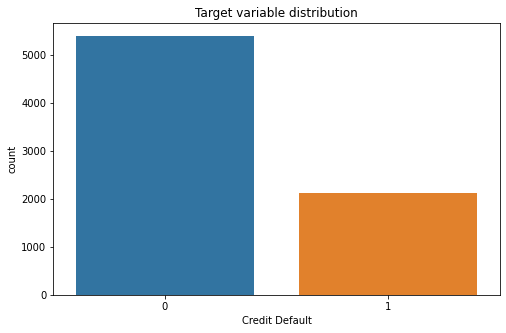

In [677]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

In [678]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Очевидна разбалансировка классов, которую необходимо будет выровнять**

In [679]:
df_train['Purpose'].dtype

dtype('O')

### Матрица корреляций

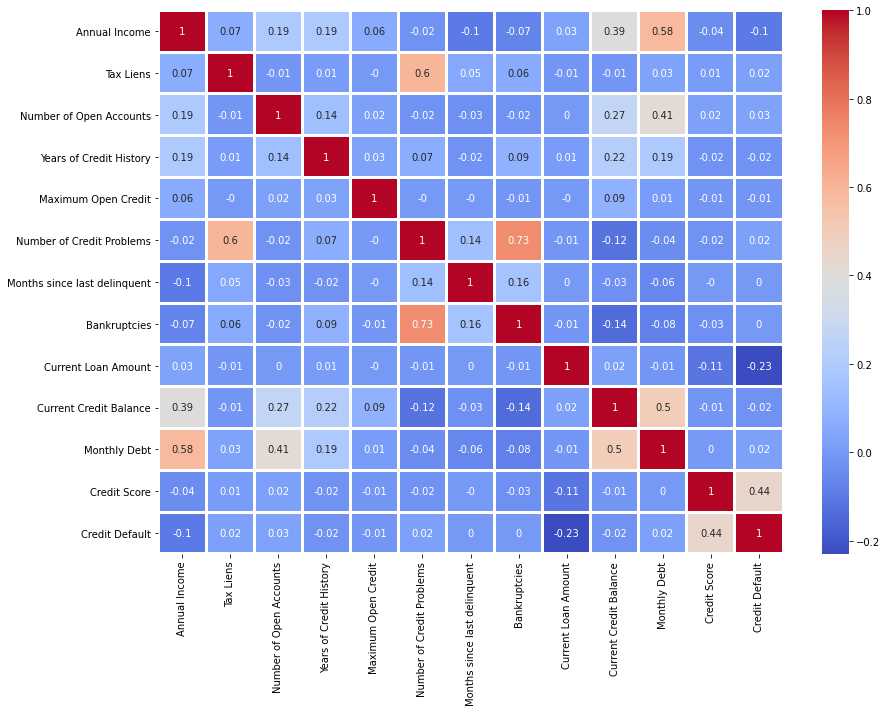

In [680]:
corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix,2)
plt.figure(figsize = (14,10))
sns.heatmap(corr_matrix, annot=True, linewidth = 2, cmap = 'coolwarm')
plt.show()

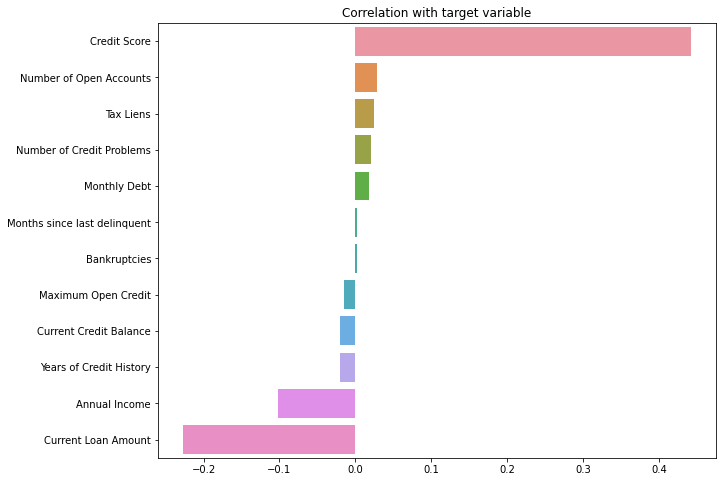

In [681]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

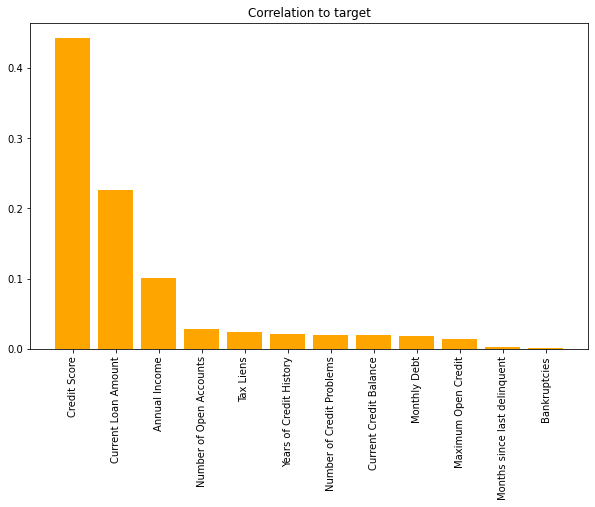

In [682]:
corr_matrix = df_train.corrwith(df_train['Credit Default'])
corr_matrix = df_train.loc[:, df_train.columns != 'Credit Default'].corrwith(df_train['Credit Default']).abs().sort_values(ascending=False)
plt.figure(figsize = (10, 6))
plt.bar(corr_matrix.index, corr_matrix.values, color = 'orange')
plt.title('Correlation to target')
plt.xticks(rotation='vertical')
plt.show()

### Изучение  признаков

In [683]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [684]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Признаки, содержащие пропуски - **Annual Income, Months since last delinquent, Years in current job, Bankruptcies, Credit Score**

### Вещественные признаки

Annual Income


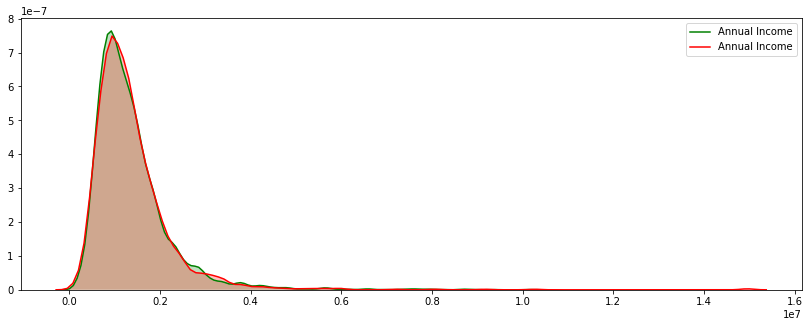

Tax Liens


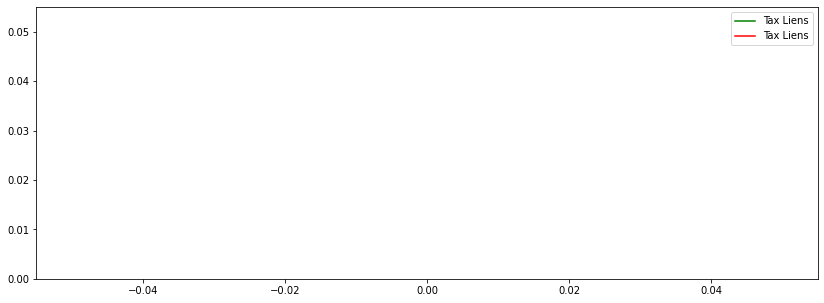

Number of Open Accounts


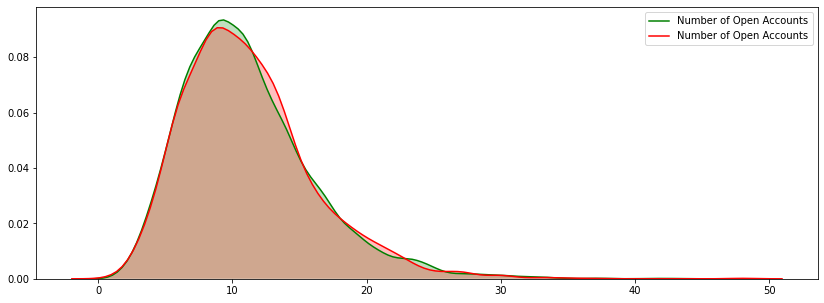

Years of Credit History


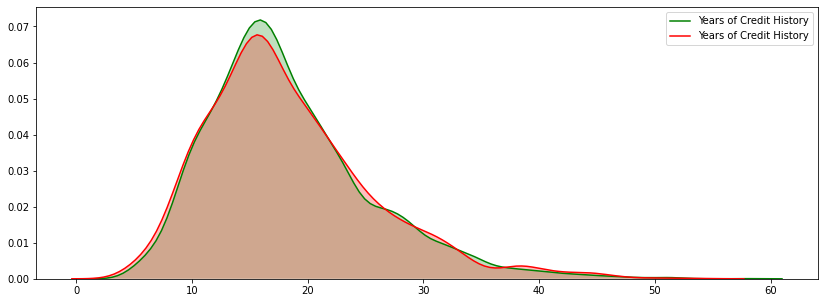

Maximum Open Credit


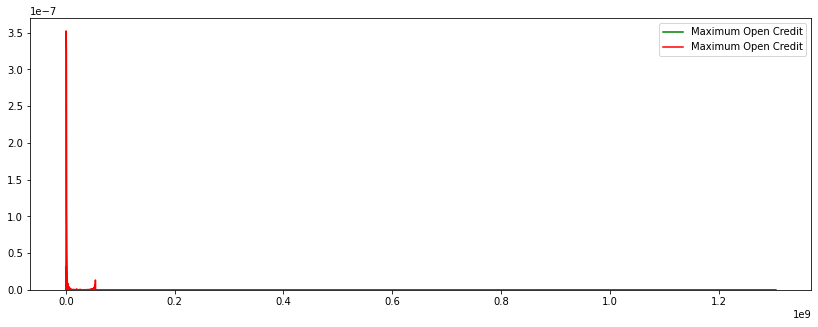

Number of Credit Problems


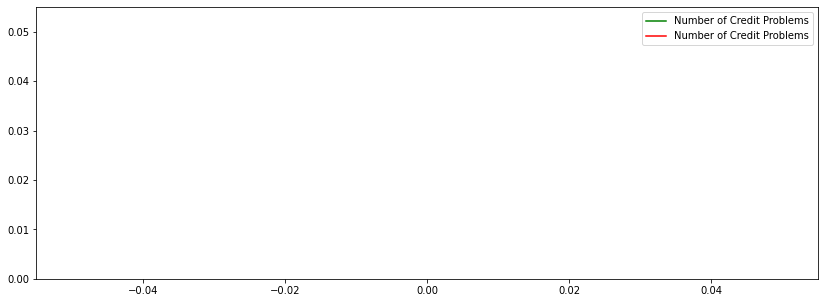

Current Loan Amount


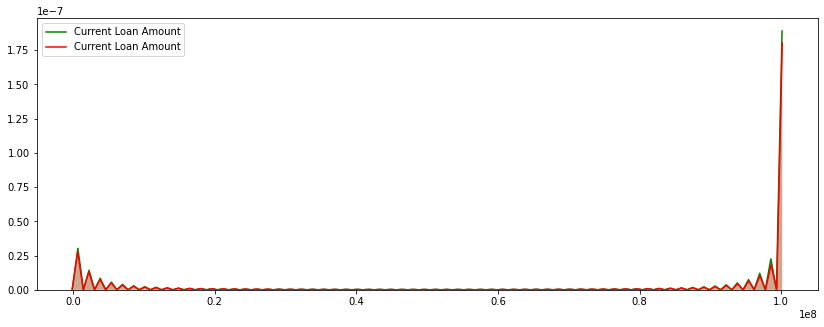

Credit Score


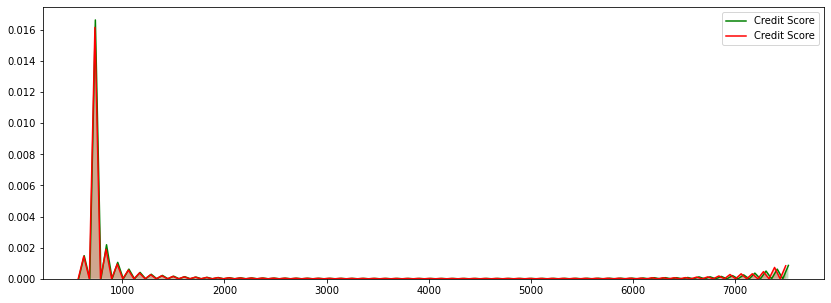

Months since last delinquent


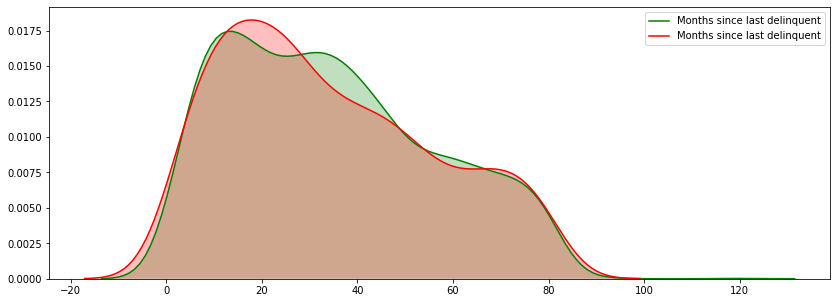

Current Credit Balance


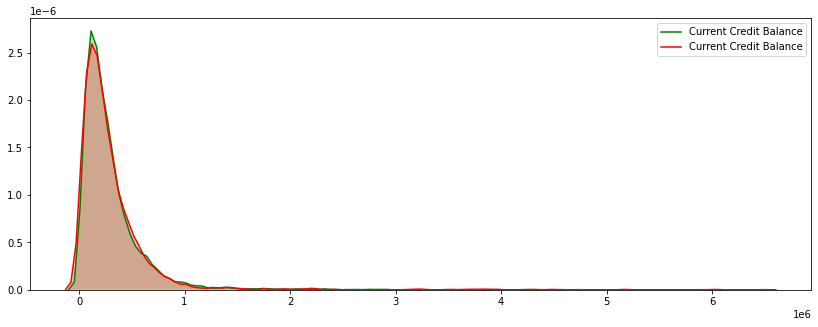

Monthly Debt


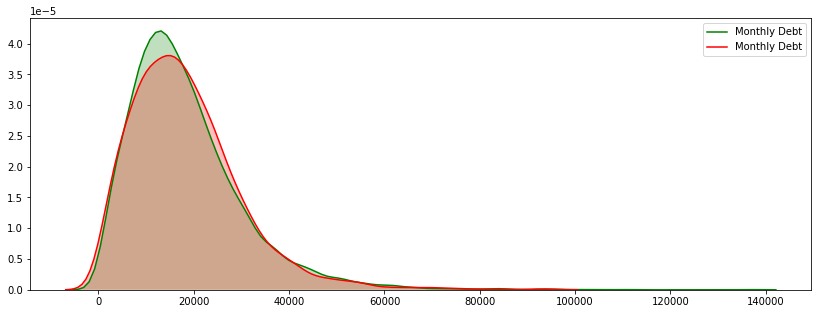

Bankruptcies


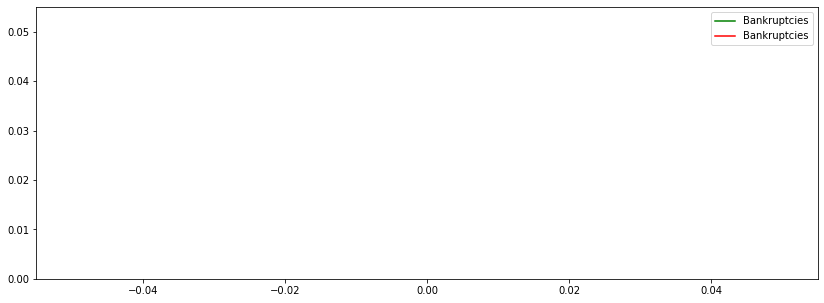

In [685]:
#Рассмотрим распределение на тренировочном и тестовом датасетах
for col in NUM_FEATURE_NAMES:
    print(col)
    plt.figure(figsize = (14,5))
    sns.kdeplot(df_train[col], shade=True,  color='g')
    sns.kdeplot(df_test[col], shade=True, color='r')
    plt.show()

Можно сделать вывод, что в целом распределение большинства количественных признаков на тренировочном и тестовом наборе данных похоже|

In [686]:
for num, column in enumerate(df_train[NUM_FEATURE_NAMES]):
    print(str(num) + ' : ' + str(column) + '\n\n' + str(df_train[column].value_counts()) + '\n' + '-' * 100 + '\n')

0 : Annual Income

1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64
----------------------------------------------------------------------------------------------------

1 : Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
----------------------------------------------------------------------------------------------------

2 : Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      

### Изучим отдельные признаки подробнее

#### Credit Score - наибольшая корреляция с целевой переменной

Этот признак не описан среди заданных, допустим, что он предполагает некую характеристику клиента банка, расчитанную аналитиками на основе неких показателей. Поэтому отнесем его к категориальным

In [687]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
629.0       1
606.0       1
6830.0      1
6670.0      1
620.0       1
Name: Credit Score, Length: 268, dtype: int64

In [688]:
df_train['Credit Score'].value_counts().count()

268

In [689]:
df_train['Credit Score'].sort_values(ascending = False)

2213    7510.0
3688    7510.0
2408    7500.0
355     7500.0
1363    7490.0
         ...  
7482       NaN
7492       NaN
7494       NaN
7498       NaN
7499       NaN
Name: Credit Score, Length: 7500, dtype: float64

In [690]:
df_train['Credit Score'].isnull().sum()

1557

Поскольку предполагаем, что этот признак - некая расчетная величина, определенная по некоторым признакам клиентов, количество ее значений вполне доступимо может быть большим.

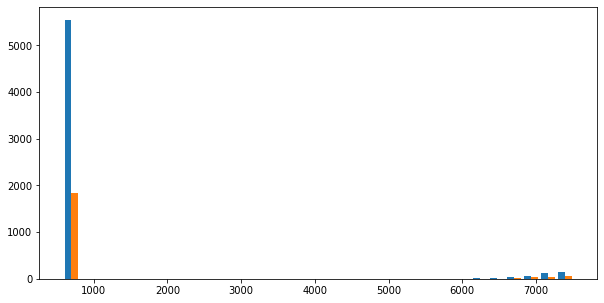

In [691]:
plt.figure(figsize=(10,5))
plt.hist([df_train['Credit Score'], df_test['Credit Score']], bins = 30)
plt.show()

Виден просвет между значениями примерно 700 и 6000, после чего идет длинный "хвост" из явно небольшого количества наблюдений. Расчитаем сколько их и какое значение наибольшее до этого "хвоста"

In [692]:
df_train.loc[df_train['Credit Score'] <=1000, 'Credit Score'].max()

751.0

In [693]:
df_train['Credit Score'].min()

585.0

In [694]:
df_train.loc[df_train['Credit Score'] >= 1000, 'Credit Score'].count()

400

Значений хвоста немного, но их распределение на трейне и тесте похоже, поэтому предположим, что это не выброс, и эта отличительная характеристика может быть полезна при обучении. При наибольшей корреляционной связи с таргетом, эти значения могут оказать важное влияние на точность модели

Оставшиеся значения распределены в промежутке между 585 и 751 (относительно генеральной совокупность этот интервал маленький) -> вполне допустимо заполнить пропуски медианой

In [695]:
df_train['Credit Score'].isnull().sum() #должен быть 0 после заполнения пропусков

1557

#### Annual Income - Годовой доход

In [696]:
df_train['Annual Income'].isnull().sum()

1557

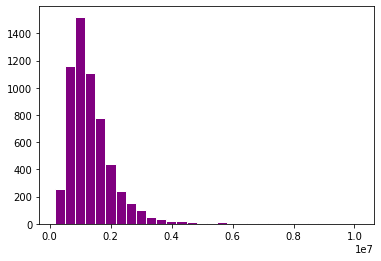

In [697]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(df_train['Annual Income'], bins = 30, color = 'purple', ec = 'white')

plt.show()

Доход - очень индивидуальный признак, повторяющихся значений очевидно мало, в данном случае все его значения можно допустить и не причислять к выбросам

In [698]:
#Вариант 1. 
# Добавляем признак о неизвестном доходе и присваиваю всем наблюдениям 0
#df_train['Unknown Income'] = 0
# Всем, у кого неизвестна зарплата делаем пометку "1" в столбец unknown_income
#df_train.loc[(df_train['Annual Income'].isnull()), 'Unknown Income'] = 1

# Вариант 2

#train_df["Annual Income"] = train_df["Annual Income"].fillna(train_df["Annual Income"].median(), inplace = True)



#### Current Loan Amount - Текущий кредитный баланс

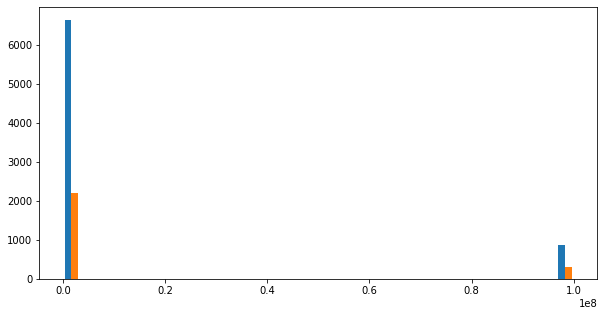

In [699]:
plt.figure(figsize=(10,5))
plt.hist([df_train['Current Loan Amount'], df_test['Current Loan Amount']], bins = 30)
plt.show()

In [700]:
df_train['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
216106.0        5
265826.0        5
             ... 
104324.0        1
201080.0        1
427812.0        1
665544.0        1
191136.0        1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [701]:
df_train['Current Loan Amount'].max()

99999999.0

In [702]:
df_train.loc[df_train['Current Loan Amount'] == 100000000, 'Current Loan Amount'].count()

0

In [703]:
df_train['Current Loan Amount'].isnull().sum()

0

Значение 100000000.0 будем считать выбросом. Далее рассмотрим, как лучше всего его обработать

Можно допустить, что это не выброс, а только взятые кредиты, но такое большое количество одинаковых значений выглядит странно. Рассмотрим разные варианты работы с этим признаком

In [704]:
# Заменим отличительно большие значения признака (выбросы), определенные выше, на среднее значение
#df_train.loc[df_train["Current Loan Amount"] > 1000000, "Current Loan Amount"] = df_train.loc[df_train["Current Loan Amount"] <= 1000000, "Current Loan Amount"].mean()

In [705]:
df_train['Current Loan Amount'].max()

99999999.0

#### Months since last delinquent - Количество месяцев с последней просрочки платежа

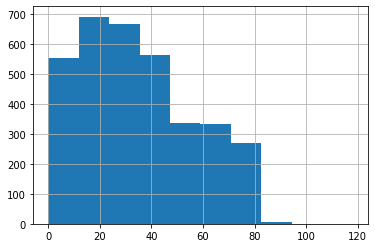

In [706]:
df_train['Months since last delinquent'].hist()
plt.show()

In [707]:
df_train['Months since last delinquent'].value_counts()

14.0     76
29.0     71
33.0     68
8.0      68
19.0     65
         ..
84.0      1
86.0      1
91.0      1
118.0     1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [708]:
df_train['Months since last delinquent'].isnull().sum()

4081

**В этом признаке самое большое количество пропусков**

In [709]:
df_train['Months since last delinquent'].isnull().sum()

4081

In [710]:
df_train['Months since last delinquent'].min()

0.0

In [711]:
df_train.loc[df_train['Months since last delinquent'] == 0, 'Months since last delinquent'].count()

18

Предположим, что пропуски в данном случае неслучайны и они обозначают, что просрочки платежа нет. Поэтому заменим. NaN на 0.

В данном случае следует добавить бинарный признак, показывающий наличие или отсутствие задолженности (0 - значение признака 0, 1-значения признака, отличные от 0)

#### Credit Score

Этот признак не описан среди заданных, допустим, что он предполагает некую характеристику клиента банка, расчитанную аналитиками на основе неких показателей. Поэтому отнесем его к категориальным

In [712]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
629.0       1
606.0       1
6830.0      1
6670.0      1
620.0       1
Name: Credit Score, Length: 268, dtype: int64

In [713]:
df_train['Credit Score'].value_counts().count()

268

In [714]:
df_train['Credit Score'].sort_values(ascending = False)

2213    7510.0
3688    7510.0
2408    7500.0
355     7500.0
1363    7490.0
         ...  
7482       NaN
7492       NaN
7494       NaN
7498       NaN
7499       NaN
Name: Credit Score, Length: 7500, dtype: float64

In [715]:
df_train['Credit Score'].isnull().sum()

1557

Поскольку предполагаем, что этот признак - некая расчетная величина, определенная по некоторым признакам клиентов, количество ее значений вполне доступимо может быть большим.

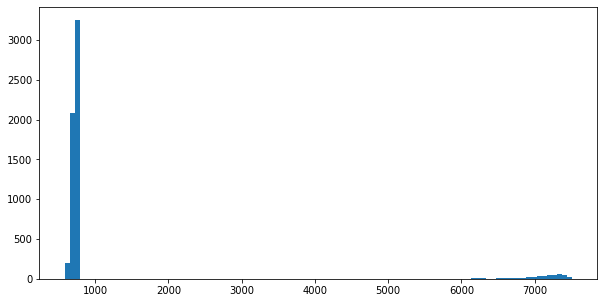

In [716]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))
ax.hist(df_train['Credit Score'], bins = 100)
plt.show()

Виден просвет между значениями примерно 700 и 6000, после чего идет длинный "хвост" из явно небольшого количества наблюдений. Расчитаем сколько их и какое значение наибольшее до этого "хвоста"

In [717]:
df_train.loc[df_train['Credit Score'] <=1000, 'Credit Score'].max()

751.0

In [718]:
df_train['Credit Score'].min()

585.0

In [719]:
df_train.loc[df_train['Credit Score'] >= 1000, 'Credit Score'].count()

400

Значений хвоста немного, но их распределение на трейне и тесте похоже, поэтому предположим, что это не выброс, и эта отличительная характеристика может быть полезна при обучении.

Оставшиеся значения распределены в промежутке между 585 и 751 (относительно генеральной совокупность этот интервал маленький) -> вполне допустимо заполнить пропуски медианой

In [720]:
df_train['Credit Score'].isnull().sum() #должен быть 0 после заполнения пропусков

1557

**Поскольку у признака Credit Score большое количество пропусков и очевидно, что он будет важен для модели, создадим дополнительный признак метку, где обозначим клиентов, у которых не был это показатель известен - unknown_credit_score**

### Категориальные признаки

**Изучим распределение категориальных признаков на тренировочном и тестовом наборах данных в зависимости от разных признаков (num_feature)**

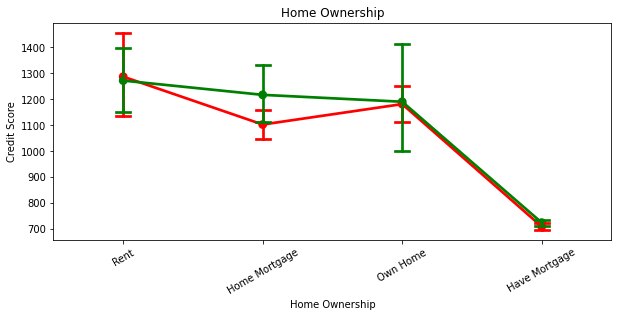

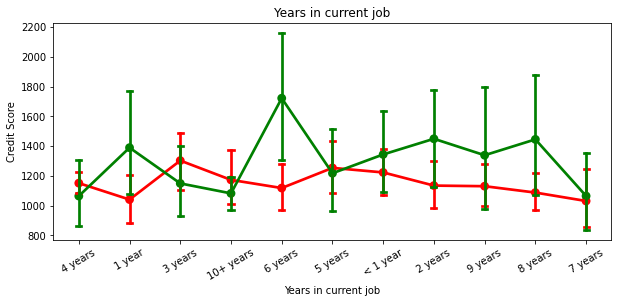

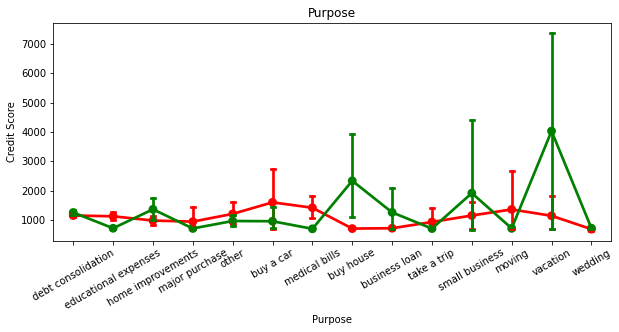

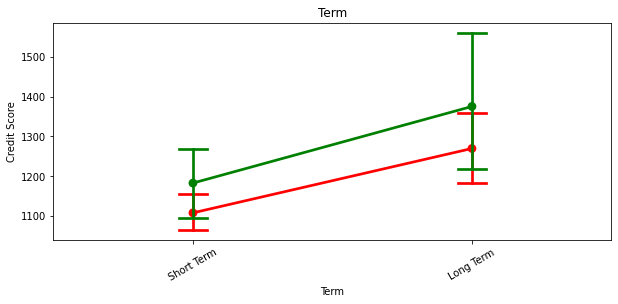

In [721]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=(10,4))
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.xticks(rotation=30) 
    plt.title(col)
    plt.show()

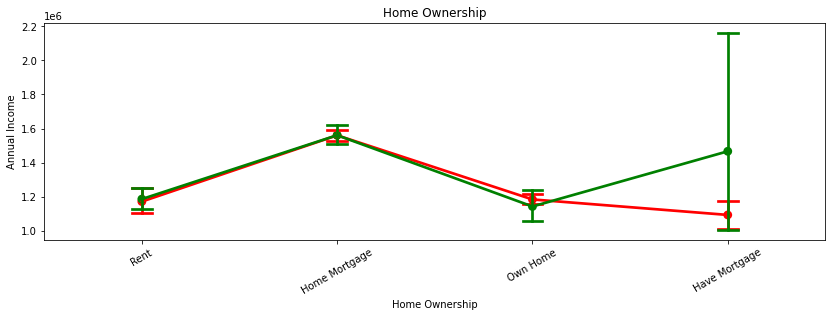

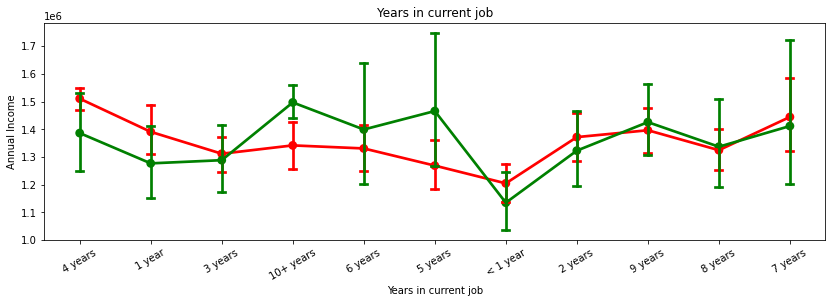

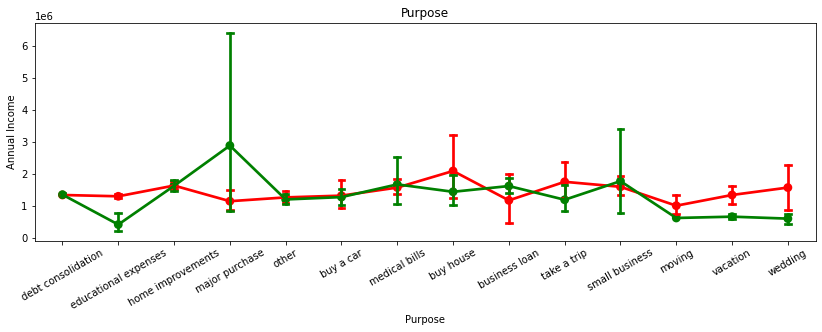

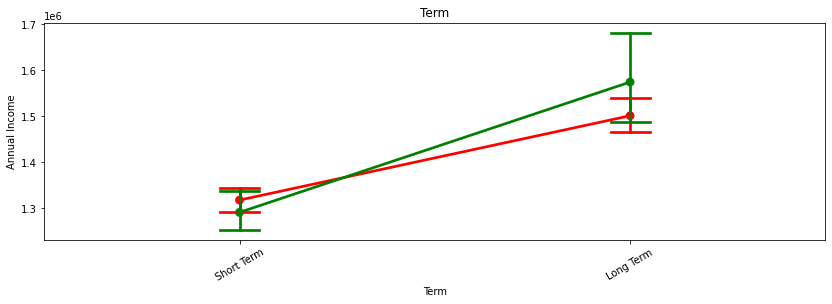

In [722]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=(14,4))
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.xticks(rotation=30) 
    plt.title(col)
    plt.show()

#### Years in Current Job

In [723]:
years_job = df_train['Years in current job'].value_counts()

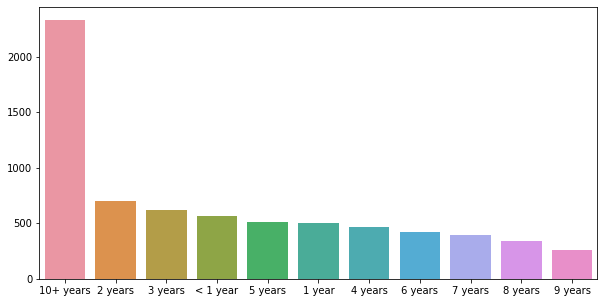

In [724]:
plt.figure(figsize = (10,5))
sns.barplot(years_job.index, years_job.values)
plt.show()

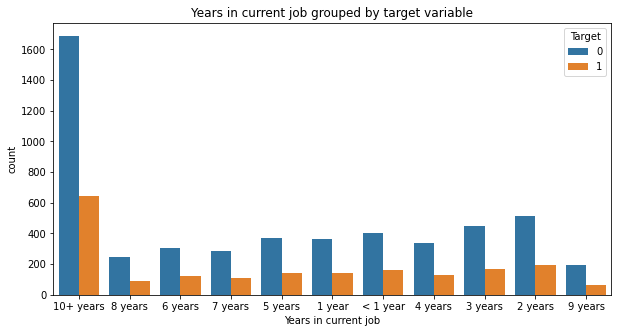

In [725]:
plt.figure(figsize = (10,5))

sns.countplot(x=df_train["Years in current job"], hue=df_train[TARGET_NAME], data=df_train)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [726]:
# Не забудем, что у признака были найдены пропуски
df_train['Years in current job'].isnull().sum()

371

Значений признака относительно много, а пропусков довольно мало, попробуем заполнить их рандомными значениями из имеющихся в признаке.

In [727]:
list(df_train['Years in current job'].unique())

[nan,
 '10+ years',
 '8 years',
 '6 years',
 '7 years',
 '5 years',
 '1 year',
 '< 1 year',
 '4 years',
 '3 years',
 '2 years',
 '9 years']

In [728]:
list(df_test['Years in current job'].unique())

['4 years',
 '1 year',
 '3 years',
 '10+ years',
 '6 years',
 '5 years',
 '< 1 year',
 '2 years',
 '9 years',
 '8 years',
 '7 years',
 nan]

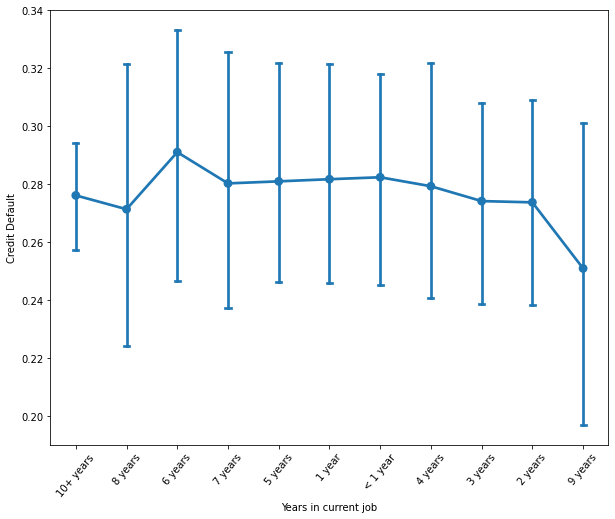

In [729]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Years in current job', y='Credit Default', data=df_train, capsize=.1,)
plt.xticks(rotation = 50)
plt.show()

#### Purpose - цель кредита

In [730]:
purpose_values = df_train['Purpose'].value_counts()

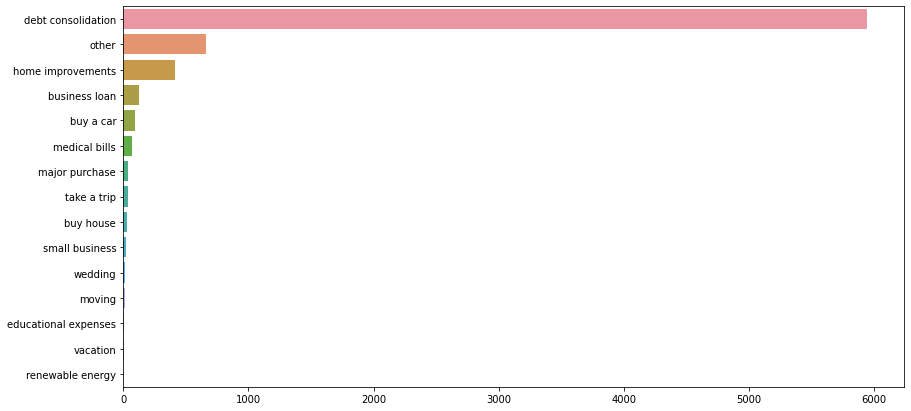

In [731]:
plt.figure(figsize = (14,7))
sns.barplot(purpose_values.values, purpose_values.index)
plt.show()

In [732]:
df_train.loc[df_train['Purpose'] == 'debt consolidation', 'Purpose'].count()

5944

In [733]:
df_train.loc[df_train['Purpose']=='renewable energy', 'Purpose'].count()

2

In [734]:
df_test.loc[df_test['Purpose']=='renewable energy', 'Purpose'].count()

0

In [735]:
#однозначно категорию renewable energy убираем
df_train.loc[df_train['Purpose']=='renewable energy', 'Purpose'] = 'debt consolidation'

In [736]:
list(df_train['Purpose'].unique())

['debt consolidation',
 'other',
 'home improvements',
 'take a trip',
 'buy a car',
 'small business',
 'business loan',
 'wedding',
 'educational expenses',
 'buy house',
 'medical bills',
 'moving',
 'major purchase',
 'vacation']

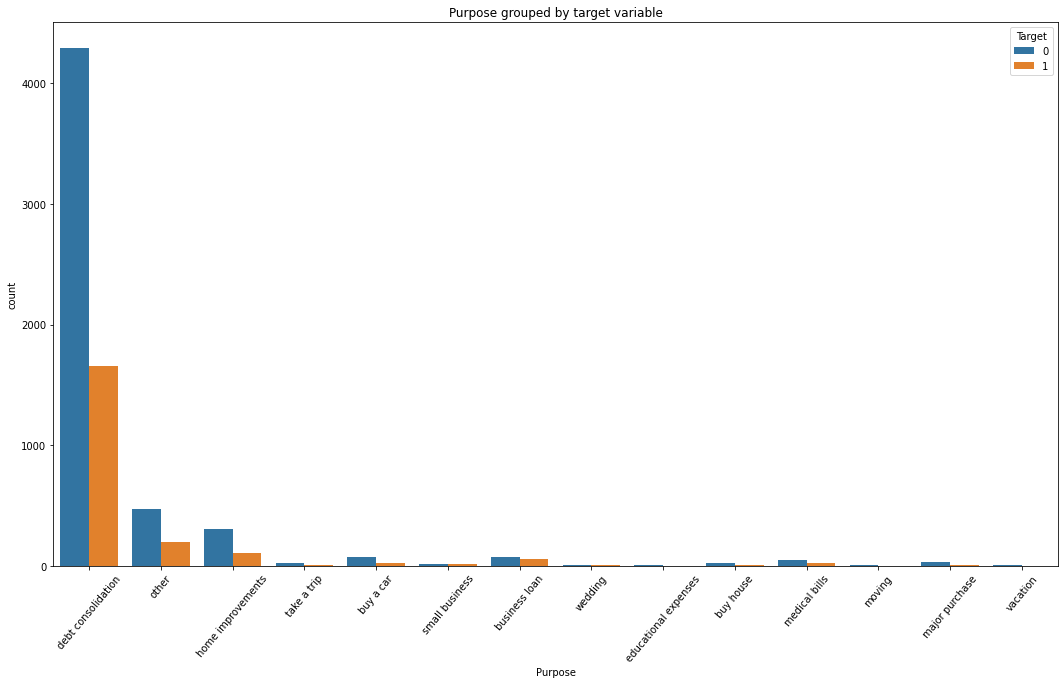

In [737]:
plt.figure(figsize = (18,10))

sns.countplot(x=df_train["Purpose"], hue=df_train[TARGET_NAME], data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.xticks(rotation = 50)

plt.show()

In [738]:
df_train['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation'], dtype=object)

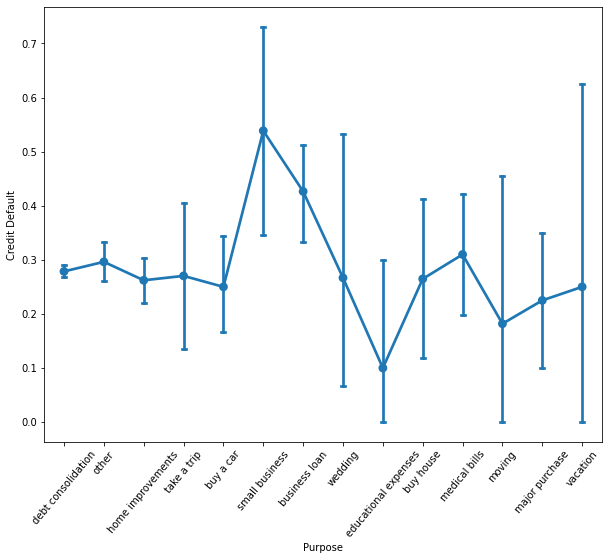

In [739]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Purpose', y='Credit Default', data=df_train, capsize=.1,)
plt.xticks(rotation = 50)
plt.show()

Проверим согласованность частот признаков, имеющих очень маленькие доли в целях изучения возмножности максимального объединения их в один признак

По графикам распределений и доверительных интервалов видно, что возможно попробовать объединить категории: 

 - take a trip & buy house & major purchase 
 - other & home improvements & debt consolidation
  Проверим p уровень значимости:


In [740]:
#возьмем за базу для изучения категорию buy house
df_train['Id'] = df_train.index
purpose_and_target = df_train.loc[df_train['Purpose'].isin(['home improvements', 'debt consolidation']), ['Id','Credit Default', 
                                                                                         'Purpose']]

In [741]:
table = purpose_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
table


Credit Default,0,1
Purpose,,
debt consolidation,4290,1656
home improvements,304,108


In [742]:
chi2, p, _, _ = chi2_contingency(table)
p

0.5087358153371229

Значения p: 
Рассмотрим категории, с похожим распределением с buy house(он находится примерно в середине нижней части графика):
* ['take a trip', 'buy house'] - 0.82
* ['take a trip', 'major purchase'] = 0.84
* ['buy house', 'major purchase'] = 0.9

* ['other', 'home improvements'] = 0.25
* ['other', 'debt consolidation'] = 0.35
* ['home improvements', 'debt consolidation'] = 0.51


Итак, попробуем объединить признаки:
['take a trip', 'buy house', 'major purchase'] -> 'other_1'
['other', 'home improvements', 'debt consolidation'] -> "other_2'

#### Home Ownership   - домовладение         

In [743]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Предположим, что Have Mortgage - выброс, возникший в результате опечатки и заменим 12 значений на Home Mortgage

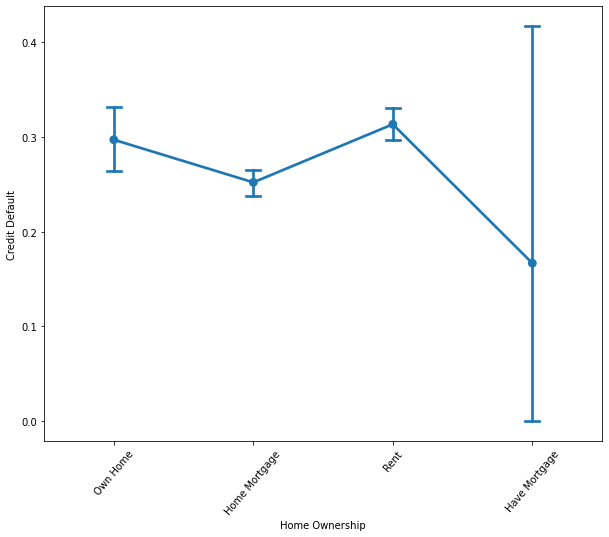

In [744]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Home Ownership', y='Credit Default', data=df_train, capsize=.1,)
plt.xticks(rotation = 50)
plt.show()

In [745]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'

#### Bankruptcies   - банкротства         

In [746]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [747]:
df_train['Bankruptcies'].isnull().sum()

14

Видимо, значение признака предполагает количество банкротств юр. лиц , зарегистрированных на клиента. Т.к. обычно бОльшая часть население не имеет зарегистрированных на себя фирм, то значение 0 преобладает. Однако есть клиенты, кто видимо неоднократно пытался начать свой бизнес и терпел неудачу, количество таких лиц стремительно сокращается. Допускаю, что значения признака адекватны в данном случае.

Пропуски имеет смысл заполнить нулями, пропусков мало и это допустимо

In [748]:
#на графике выше видно , что значения на трейне и тесте отличаются, изучим подробнее
list(df_train['Bankruptcies'].unique())

[1.0, 0.0, 3.0, nan, 2.0, 4.0]

In [749]:
list(df_test['Bankruptcies'].unique())

[0.0, 1.0, 5.0, nan, 2.0, 3.0, 4.0]

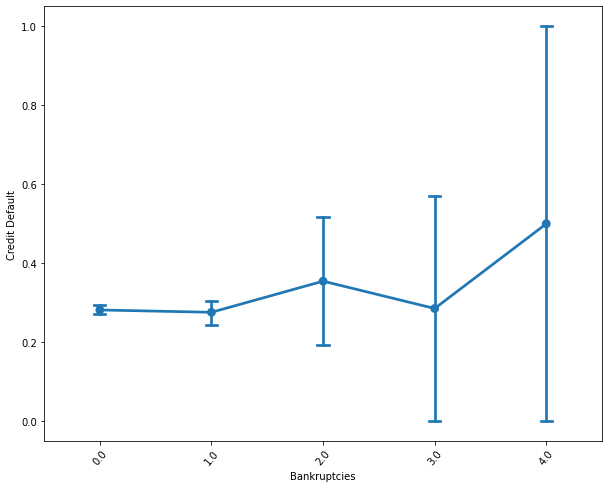

In [750]:
plt.figure(figsize=(10, 8))

sns.pointplot(x='Bankruptcies', y='Credit Default', data=df_train, capsize=.1,)
plt.xticks(rotation = 50)
plt.show()

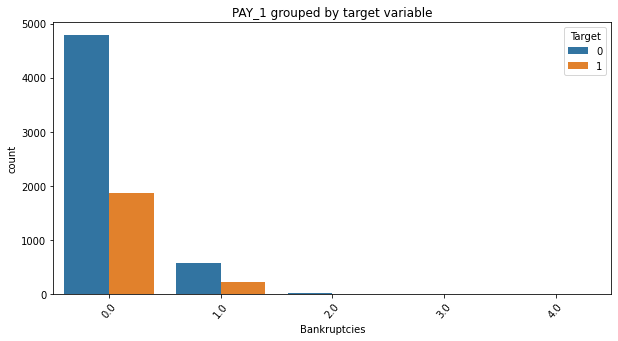

In [751]:
plt.figure(figsize = (10,5))

sns.countplot(x=df_train["Bankruptcies"], hue=df_train[TARGET_NAME], data=df_train)
plt.title('PAY_1 grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.xticks(rotation = 50)

plt.show()

In [752]:
#df_train['Bankruptcies'] = df_train['Bankruptcies'].astype('object')

In [753]:
#df_train['Bankruptcies'].unique()

In [754]:
#bankr_and_target = df_train.loc[df_train['Bankruptcies'].isin([1.0, 2.0]), ['Id','Credit Default', 'Bankruptcies']]

In [755]:
#table= bankr_and_target.pivot_table(values='Id', index='Bankruptcies', columns='Credit Default', aggfunc='count')
#table

In [756]:
#chi2, p, _, _ = chi2_contingency(table)
#p

Объединение категорий 1 и 0 не показало себя в модели.

In [757]:
df_train.drop('Id', axis = 1, inplace = True)

### Разбиение на train и test

In [758]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21, stratify = y)

In [759]:
X_train.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Current Loan Amount', 'Bankruptcies',
       'Months since last delinquent', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Home Ownership',
       'Years in current job', 'Purpose', 'Term'],
      dtype='object')

In [760]:
y_train.values

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

 ## Обработка признаков -  Feature Engineering  

**Python код для преобразования данных** -  в процессе формирования...

In [761]:
list(df_train['Purpose'].unique())

['debt consolidation',
 'other',
 'home improvements',
 'take a trip',
 'buy a car',
 'small business',
 'business loan',
 'wedding',
 'educational expenses',
 'buy house',
 'medical bills',
 'moving',
 'major purchase',
 'vacation']

In [762]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.annual_income_median = None
        self.current_loan_am_mean = None
        self.credit_score_median = None
        self.var_years_in_current_job = None
        self.years_unique = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет статистик
        self.annual_income_median = df['Annual Income'].median()
        
        self.current_loan_am_mean = df['Current Loan Amount'].mean()
        self.credit_score_median = df['Credit Score'].median()
        self.years_unique = df['Years in current job'].unique()[1:]

    def transform(self, df):
        """Трансформация данных"""
        
        # 0. Добавление новых признаков на основе проблемных (пропуски, выбросы)
        
        #отметит отдельно клиентов с неизвестным уровнем дохода
        df['unknown_annual_income'] = 0
        df.loc[(df['Annual Income'].isnull()), 'unknown_annual_income'] = 1
        
        #аналогично с неизвестным Credit Score
        df['unknown_credit_score'] = 0
        df.loc[(df['Credit Score'].isnull()), 'unknown_credit_score'] = 1
        
        #На графике признака Credit Score были обнаружены сильно отличающиеся в бОльшую сторону значения
        #поскольку однозначно утверждать, что это выброс нельзя, сделаем признак-метку
        
        df['Credit score_outline']=0
        df.loc[df['Credit Score']>5000, 'Credit score_outline']=1 
        
        # 1. Заполним пропуски
        
        df['Annual Income'].fillna(self.annual_income_median, inplace=True)
        df['Credit Score'].fillna(self.credit_score_median, inplace = True)
        df['Months since last delinquent'].fillna(0, inplace=True)
        df['Years in current job'].fillna(random.choice(self.years_unique), inplace=True)
        df['Bankruptcies'].fillna(0 , inplace=True)
        
        
        # 2. Выбросы (outliers)
        
        df.loc[df["Current Loan Amount"] > 1000000, "Current Loan Amount"] = df.loc[df["Current Loan Amount"]
                                                                        <= 1000000, "Current Loan Amount"].mean()

        df.loc[df["Current Loan Amount"] > 99999999, "Current Loan Amount"] = df.loc[df["Current Loan Amount"]
                                                                        <= 99999999, "Current Loan Amount"].mean()
        # 3. Новые фичи (features)
        
        # 1) Бинарный признак о наличии задолженности на основе признака Months since last delinquent - has_delay

        df['has_delay'] = 1
        df.loc[(df['Months since last delinquent'] == 0), 'has_delay'] = 0
        
        
        # 4) Признак-метка клиента с отсутствием проблем с кредитами - no problems
        df['No problems'] = 1
        df['No problems'] = (df['Tax Liens'] == 0) & (df['Bankruptcies'] == 0) & (df['Number of Credit Problems']\
                                                                                  == 0)
        
        # 5)  Доля дохода клиента, которая уходит на кредит - part_of_income_for_credit
        
        df['part_of_income_for_credit'] = df['Monthly Debt']*12/df['Annual Income']
        
        # 4. Обработка категорий - Purpose, Years in current job, Bankruptcies, Home Ownership, Term
        
        #Purpose
        
        df.loc[df['Purpose'].isin(['take a trip', 'buy house', 'major purchase']),
                                  'Purpose'] = 'other_1'
        df.loc[df['Purpose'].isin(['other', 'home improvements', 'debt consolidation'] ),
                                  'Purpose'] = 'other_2'
        
        #Пробовала закодировать признаки - модель ухудшилась
        '''
        df['purpose_cat'] = 0
        df.loc[df['Purpose'].isin(['take a trip', 'buy house', 'major purchase']), 'purpose_cat'] = 0
        df.loc[df['Purpose'].isin(['other', 'home improvements', 'debt consolidation']) , 'purpose_cat'] = 1
        df.loc[df['Purpose'] == 'buy a car', 'purpose_cat'] = 2
        df.loc[df['Purpose'] == 'small business', 'purpose_cat'] = 3
        df.loc[df['Purpose'] == 'business loan', 'purpose_cat'] = 4
        df.loc[df['Purpose'] == 'wedding', 'purpose_cat'] = 5
        df.loc[df['Purpose'] == 'educational expenses', 'purpose_cat'] = 6
        df.loc[df['Purpose'] == 'medical bills', 'purpose_cat'] = 7
        df.loc[df['Purpose'] == 'moving', 'purpose_cat'] = 8
        df.loc[df['Purpose'] == 'vacation', 'purpose_cat'] = 9
        '''
        
        #df.drop('Purpose', axis=1, inplace = True)
         # Переведем уникальные значения в дамми 
        df = pd.concat([df, pd.get_dummies(df['Purpose'])], axis=1)
       
        
        # Years In Current Job - кодирование порядковыми номерами по возрастанию срока работы в текущем месте
        
        df['experience_cat'] = 0
        df.loc[df['Years in current job'] == '< 1 year', 'experience_cat'] = 0
        df.loc[df['Years in current job'] == '1 year', 'experience_cat'] = 1
        df.loc[df['Years in current job'] == '2 years', 'experience_cat'] = 2
        df.loc[df['Years in current job'] == '3 years', 'experience_cat'] = 3
        df.loc[df['Years in current job'] == '4 years', 'experience_cat'] = 4
        df.loc[df['Years in current job'] == '5 years', 'experience_cat'] = 5
        df.loc[df['Years in current job'] == '6 years', 'experience_cat'] = 6
        df.loc[df['Years in current job'] == '7 years', 'experience_cat'] = 7
        df.loc[df['Years in current job'] == '8 years', 'experience_cat'] = 8
        df.loc[df['Years in current job'] == '9 years', 'experience_cat'] = 9
        df.loc[df['Years in current job'] == '10+ years', 'experience_cat'] = 10
        #df = df.drop('Years in current job', axis = 1)
        
        df = pd.concat([df, pd.get_dummies(df['Years in current job'])], axis=1)
        df.rename(columns = {'< 1 year': 'less 1 year', '10+ years': 'more 10 years'}, inplace = True)
       
        #Term - бинарное кодирование
        df = pd.concat([df, pd.get_dummies(df['Term'])], axis=1)
        
        # Home Ownership
        
        df = pd.concat([df, pd.get_dummies(df['Home Ownership'])], axis=1)
        
        return df

In [763]:
pipe = DataPipeline()
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
df_test = pipe.transform(df_test)

In [764]:
X_train.isnull().sum()

Annual Income                   0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Current Loan Amount             0
Bankruptcies                    0
Months since last delinquent    0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Home Ownership                  0
Years in current job            0
Purpose                         0
Term                            0
unknown_annual_income           0
unknown_credit_score            0
Credit score_outline            0
has_delay                       0
No problems                     0
part_of_income_for_credit       0
business loan                   0
buy a car                       0
educational expenses            0
medical bills                   0
moving                          0
other_1                         0
other_2                         0
small business

In [765]:
list(X_train.columns)

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Bankruptcies',
 'Months since last delinquent',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership',
 'Years in current job',
 'Purpose',
 'Term',
 'unknown_annual_income',
 'unknown_credit_score',
 'Credit score_outline',
 'has_delay',
 'No problems',
 'part_of_income_for_credit',
 'business loan',
 'buy a car',
 'educational expenses',
 'medical bills',
 'moving',
 'other_1',
 'other_2',
 'small business',
 'vacation',
 'wedding',
 'experience_cat',
 '1 year',
 'more 10 years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 'less 1 year',
 'Long Term',
 'Short Term',
 'Home Mortgage',
 'Own Home',
 'Rent']

### Стандартизация данных


In [766]:
#scaler = StandardScaler()

#X_train_scaled = scaler.fit_transform(X_train[NUM_FEATURE_NAMES])
#X_test_scaled = scaler.transform(X_test[NUM_FEATURE_NAMES])

### Балансировка классов

In [767]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [768]:
#Подготовим датасет для балансировки классов

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_for_balancing = df_for_balancing.drop(columns = df_for_balancing.select_dtypes(include='object').columns)
df_for_balancing.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Current Loan Amount,Bankruptcies,Months since last delinquent,Current Credit Balance,...,7 years,8 years,9 years,less 1 year,Long Term,Short Term,Home Mortgage,Own Home,Rent,Credit Default
9,1175454.0,0.0,10.0,24.6,511302.0,0.0,572880.000000,0.0,6.0,205333.0,...,0,0,0,0,1,0,1,0,0,1
468,2443514.0,0.0,10.0,20.5,83380.0,0.0,310198.475248,0.0,9.0,65892.0,...,0,0,0,0,1,0,0,0,1,0
2222,2321040.0,0.0,9.0,18.7,665258.0,1.0,310198.475248,0.0,39.0,406201.0,...,0,0,0,0,0,1,1,0,0,0
2611,1175454.0,0.0,8.0,16.9,715330.0,0.0,420222.000000,0.0,0.0,337307.0,...,0,1,0,0,0,1,1,0,0,0
1750,1175454.0,0.0,16.0,22.6,6052442.0,0.0,787644.000000,0.0,0.0,867692.0,...,0,0,0,0,1,0,1,0,0,1


In [769]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3609
1    2832
Name: Credit Default, dtype: int64

**over sampling**: 0 -   3609, 1 -   2832


**under sampling**: 0 -   1416, 1 -   1416


**tomek**: 0 -   3239, 1 -   1455

**smote**: 0 -   3609, 1 -   3609

Выбираем smote 

In [770]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [771]:
X_train_balanced.shape

(6441, 45)

In [772]:
X_train_balanced.head()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Current Loan Amount,Bankruptcies,Months since last delinquent,Current Credit Balance,...,6 years,7 years,8 years,9 years,less 1 year,Long Term,Short Term,Home Mortgage,Own Home,Rent
1487,959557.0,0.0,10.0,14.2,0.0,0.0,221672.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0,0
3086,1175454.0,0.0,9.0,14.3,2732444.0,0.0,604670.0,0.0,0.0,894387.0,...,0,0,0,0,0,0,1,0,0,1
3611,966055.0,0.0,15.0,16.6,604252.0,0.0,230428.0,0.0,30.0,215004.0,...,0,0,0,0,0,0,1,0,1,0
3831,2853895.0,0.0,11.0,25.4,1571878.0,0.0,223278.0,0.0,0.0,264727.0,...,1,0,0,0,0,0,1,0,1,0
4118,1175454.0,0.0,11.0,39.0,1421970.0,1.0,787248.0,1.0,0.0,847362.0,...,0,0,0,0,0,1,0,0,0,1


## Построение и оценка моделей. Выбор лучшей

####  Функции для оценки моделей

In [773]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [774]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

### Определим признаки для построения модели
В процессе доработки, подбор признаков для модели

In [775]:
list(X_train_balanced.columns)

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Bankruptcies',
 'Months since last delinquent',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'unknown_annual_income',
 'unknown_credit_score',
 'Credit score_outline',
 'has_delay',
 'No problems',
 'part_of_income_for_credit',
 'business loan',
 'buy a car',
 'educational expenses',
 'medical bills',
 'moving',
 'other_1',
 'other_2',
 'small business',
 'vacation',
 'wedding',
 'experience_cat',
 '1 year',
 'more 10 years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 'less 1 year',
 'Long Term',
 'Short Term',
 'Home Mortgage',
 'Own Home',
 'Rent']

In [776]:
BASE_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Years in current job', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Home Ownership',
                    'Term', 'Purpose', 'Bankruptcies', 'part_of_income_for_credit' ]

NEW_FEATURE_NAMES = [] # признаки, которые добавились в результате работы с категориями и созданием новых фичей

CAT_FEATURE_NAMES = ['Purpose', 'Years in current job', 'Home Ownership', 'Term']

# в тотал запишем  признаки для построения модели, включая созданные новые, не включая категориальные (указаны отдельно)
TOTAL_FEATURE_NAMES = ['Annual Income',
                     'Tax Liens',
                     'Number of Open Accounts',
                     'Years of Credit History',
                     'Maximum Open Credit',
                     'Number of Credit Problems',
                     'Current Loan Amount',
                     'Bankruptcies',
                     'Months since last delinquent',
                     'Current Credit Balance',
                     'Monthly Debt',
                     'Credit Score',
                    # 'unknown_annual_income',
                    # 'unknown_credit_score',
                     'Credit score_outline',
                     'has_delay',
                     'No problems',
                     'part_of_income_for_credit',
                     'business loan',
                     'buy a car',
                     'educational expenses',
                     'medical bills',
                     'moving',
                     'other_1',
                     'other_2',
                     'small business',
                     'vacation',
                     'wedding',
                     #'experience_cat',
                     '1 year',
                     'more 10 years',
                     '2 years',
                     '3 years',
                     '4 years',
                     '5 years',
                     '6 years',
                     '7 years',
                     '8 years',
                     '9 years',
                     'less 1 year',
                     'Long Term',
                     'Short Term',
                     'Home Mortgage',
                     'Own Home',
                     'Rent'
                      ]


In [777]:
X_train_ = X_train.copy()
X_train_ = X_train_[TOTAL_FEATURE_NAMES]
X_train_balanced = X_train_balanced[TOTAL_FEATURE_NAMES]

X_test_ = X_test.copy()
X_test_ = X_test_[TOTAL_FEATURE_NAMES]

In [778]:
X_train_balanced.shape

(6441, 42)

In [779]:
y_train_balanced.value_counts()

0    3609
1    2832
Name: Credit Default, dtype: int64

### Построим модели, обучаясь на сбалансированных данных

### *Логистическая регрессия*

In [780]:
model_lr = LogisticRegression()
model_lr.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced, X_test_, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.81      0.71      3609
           1       0.63      0.42      0.51      2832

    accuracy                           0.64      6441
   macro avg       0.64      0.61      0.61      6441
weighted avg       0.64      0.64      0.62      6441

TEST

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1778
           1       0.45      0.43      0.44       697

    accuracy                           0.69      2475
   macro avg       0.62      0.62      0.62      2475
weighted avg       0.69      0.69      0.69      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1415  363
1                394  303


### *Дерево решений*

Рассмотрим на сбалансированном трейне и создадим балансировку с помощью параметров

In [781]:
dtree_model = DecisionTreeClassifier(random_state=21,
                                    max_depth=5,
                                     )
dtree_model.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced, X_test_, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.81      0.71      3609
           1       0.63      0.42      0.51      2832

    accuracy                           0.64      6441
   macro avg       0.64      0.61      0.61      6441
weighted avg       0.64      0.64      0.62      6441

TEST

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1778
           1       0.45      0.43      0.44       697

    accuracy                           0.69      2475
   macro avg       0.62      0.62      0.62      2475
weighted avg       0.69      0.69      0.69      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1415  363
1                394  303


In [782]:
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:1, 1:2.56},
                                    max_depth=7
                                    )
model_tree.fit(X_train_, y_train)

evaluate_preds(model_tree, X_train_, X_test_, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      3609
           1       0.56      0.64      0.60      1416

    accuracy                           0.76      5025
   macro avg       0.71      0.72      0.71      5025
weighted avg       0.77      0.76      0.76      5025

TEST

              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1778
           1       0.45      0.53      0.49       697

    accuracy                           0.69      2475
   macro avg       0.63      0.64      0.63      2475
weighted avg       0.70      0.69      0.70      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1334  444
1                327  370


### *Случайный лес*

Рассмотрим на сбалансированном трейне и создадим балансировку с помощью параметров

In [783]:
#1. Построим модель случайного леса на сбалансированных данных

rf_model = RandomForestClassifier(random_state=21,
                                    max_depth=30,
                                 n_estimators = 250)
rf_model.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced, X_test_, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.81      0.71      3609
           1       0.63      0.42      0.51      2832

    accuracy                           0.64      6441
   macro avg       0.64      0.61      0.61      6441
weighted avg       0.64      0.64      0.62      6441

TEST

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1778
           1       0.45      0.43      0.44       697

    accuracy                           0.69      2475
   macro avg       0.62      0.62      0.62      2475
weighted avg       0.69      0.69      0.69      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1415  363
1                394  303


In [784]:
#2. Построим модель, используя встроенную балансировку - дисбаланс равен 2.55
rf_model = RandomForestClassifier(random_state=21,
                                    max_depth=30,
                                 class_weight={0:1, 1:2.56},
                                 n_estimators = 200)
rf_model.fit(X_train_, y_train)

evaluate_preds(model_lr, X_train_, X_test_, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      3609
           1       0.46      0.42      0.44      1416

    accuracy                           0.70      5025
   macro avg       0.62      0.61      0.62      5025
weighted avg       0.69      0.70      0.69      5025

TEST

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1778
           1       0.45      0.43      0.44       697

    accuracy                           0.69      2475
   macro avg       0.62      0.62      0.62      2475
weighted avg       0.69      0.69      0.69      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1415  363
1                394  303


### Бустинговые алгоритмы

### *XGBoost*

In [785]:
xgb_model = xgb.XGBClassifier(random_state=21,
                              n_estimators = 150,
                              gamma = 2
                             )
xgb_model.fit(X_train_balanced, y_train_balanced)

evaluate_preds(xgb_model, X_train_balanced, X_test_, y_train_balanced, y_test)

[12:12:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3609
           1       0.98      0.97      0.97      2832

    accuracy                           0.97      6441
   macro avg       0.97      0.97      0.97      6441
weighted avg       0.97      0.97      0.97      6441

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1778
           1       0.52      0.46      0.49       697

    accuracy                           0.73      2475
   macro avg       0.66      0.65      0.65      2475
weighted avg       0.72      0.73      0.72      2475

CONFUSION MATRIX

col_0

### *Light Boost*

In [786]:
lgbm_model = lgbm.LGBMClassifier(random_state=21, 
                                 n_estimators=100,
                                
                                )
lgbm_model.fit(X_train_balanced, y_train_balanced)

evaluate_preds(lgbm_model, X_train_balanced, X_test_, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3609
           1       0.96      0.92      0.94      2832

    accuracy                           0.95      6441
   macro avg       0.95      0.94      0.95      6441
weighted avg       0.95      0.95      0.95      6441

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1778
           1       0.54      0.46      0.50       697

    accuracy                           0.74      2475
   macro avg       0.67      0.65      0.66      2475
weighted avg       0.73      0.74      0.73      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1502  276
1                376  321


### *CATBoost*

In [787]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                    class_weights=[1,2.55])
model_catb.fit(X_train_, y_train)

evaluate_preds(model_catb, X_train_, X_test_, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3609
           1       0.79      0.90      0.84      1416

    accuracy                           0.90      5025
   macro avg       0.87      0.90      0.89      5025
weighted avg       0.91      0.90      0.91      5025

TEST

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1778
           1       0.49      0.53      0.51       697

    accuracy                           0.71      2475
   macro avg       0.65      0.66      0.65      2475
weighted avg       0.72      0.71      0.72      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1400  378
1                331  366


Настраиваем CatBoost

In [788]:
disbalance =  y_train.value_counts()[0]/y_train.value_counts()[1]
disbalance

2.5487288135593222

In [789]:
X_train = X_train[BASE_FEATURE_NAMES]
X_test = X_test[BASE_FEATURE_NAMES]

In [790]:
model_catb = catb.CatBoostClassifier(class_weights=[1, disbalance],
                                    silent = True,
                                    random_state = 21, 
                                    cat_features=CAT_FEATURE_NAMES,
                                    l2_leaf_reg = 10,
                                    eval_metric = 'F1',
                                    early_stopping_rounds = 20,
                                    use_best_model = True,
                                     custom_metric = ['Precision', 'Recall']
                                    )

model_catb.fit(X_train, y_train, plot = True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      3609
           1       0.55      0.65      0.59      1416

    accuracy                           0.75      5025
   macro avg       0.70      0.72      0.71      5025
weighted avg       0.77      0.75      0.76      5025

TEST

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      1778
           1       0.48      0.58      0.53       697

    accuracy                           0.70      2475
   macro avg       0.65      0.67      0.66      2475
weighted avg       0.72      0.70      0.71      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1334  444
1                290  407


##### Подбор гиперпараметров

In [791]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

model_catb = catb.CatBoostClassifier(**frozen_params)

In [792]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000],
          'max_depth':[3, 5, 7]}

In [793]:
cv= KFold(n_splits=3, random_state=21, shuffle=True)

In [794]:
rs = RandomizedSearchCV(model_catb, params, scoring = 'f1', cv=cv, n_jobs = -1)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000020F773C5B50>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000]},
                   scoring='f1')

In [795]:
rs.best_params_

{'n_estimators': 1000, 'max_depth': 5}

In [796]:
model_catb_params = catb.CatBoostClassifier(**frozen_params, 
                                      n_estimators=1000, 
                                      max_depth=5)

In [797]:
model_catb_params.fit(X_train, y_train, plot=True, eval_set = (X_test, y_test))

evaluate_preds(model_catb_params, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      3609
           1       0.55      0.63      0.59      1416

    accuracy                           0.75      5025
   macro avg       0.70      0.71      0.70      5025
weighted avg       0.76      0.75      0.75      5025

TEST

              precision    recall  f1-score   support

           0       0.82      0.75      0.79      1778
           1       0.48      0.58      0.53       697

    accuracy                           0.71      2475
   macro avg       0.65      0.67      0.66      2475
weighted avg       0.73      0.71      0.71      2475

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1339  439
1                291  406
